# Super-resolution UNET

In [15]:
import fastai
from fastai.vision import *
from fastai.callbacks import *

from fastai.vision.gan import *

from PIL import Image as PILImage

---

In [2]:
batch_size = 12
bs = batch_size

# unet encoder architecture
arch = models.resnet34

# image size
size = 256

# Create the data loader (ImageDataBunch)

In [3]:
data_loader = (
    ImageImageList.from_folder('../images/')
    .filter_by_func(lambda path: 'lowres' in path.parent.as_posix()) # filter to have only /lowres/ as source
    .split_by_folder()                                               # use the folders to split in train/valid
    .label_from_func(lambda path: path.parents[1]/'hires'/path.name) # change /lowres/ to /hires/ to match source with target
    
    .databunch(bs=batch_size)
    .normalize(imagenet_stats, do_x=True, do_y=True) # convert the LabelLists in ImageDataBunch and normalize to imagenet both X and Y
)

# number of classes
# I don't know why 3 (based on lesson7-superres-gan notebooks)... 
# the unet_learner need a value for c.
data_loader.c = 3

data_loader

ImageDataBunch;

Train: LabelList
y: ImageItemList (5343 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: ../images
x: ImageImageList (5343 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: ../images;

Valid: LabelList
y: ImageItemList (248 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: ../images
x: ImageImageList (248 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: ../images;

Test: None

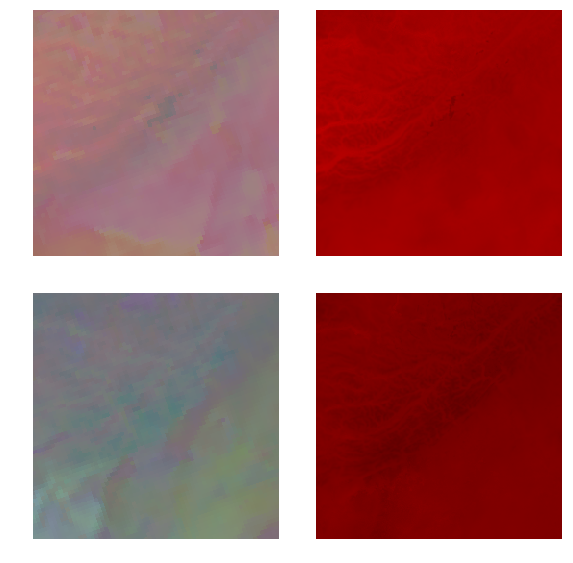

In [4]:
data_loader.show_batch(2)

---

# UNET

In [4]:
# weight decay
wd = 1e-3

y_range = (-3.,3.)

loss_gen = MSELossFlat()

---

In [5]:
def create_gen_learner():
    return unet_learner(data_loader, arch, 
                        wd=wd, blur=True, norm_type=NormType.Weight, self_attention=True, 
                        y_range=y_range, loss_func=loss_gen)

In [6]:
learn_gen = create_gen_learner()

---

## Pre-train the Generator

In [8]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

epoch,train_loss,valid_loss
1,0.012453,0.006753
2,0.004563,0.004058


In [9]:
learn_gen.save('generator-pretrain-1')

---

## Unfreeze and train some more

In [10]:
learn_gen.unfreeze()

In [11]:
learn_gen.fit_one_cycle(20, slice(1e-6,1e-3))

epoch,train_loss,valid_loss
1,0.003881,0.003594
2,0.003610,0.003443
3,0.003432,0.003273
4,0.003079,0.003146
5,0.002887,0.002840
6,0.002488,0.002636
7,0.002214,0.002761
8,0.001826,0.002746
9,0.001700,0.002536
10,0.001496,0.002264


In [12]:
learn_gen.save('generator-pretrain-2')

---

## Show results

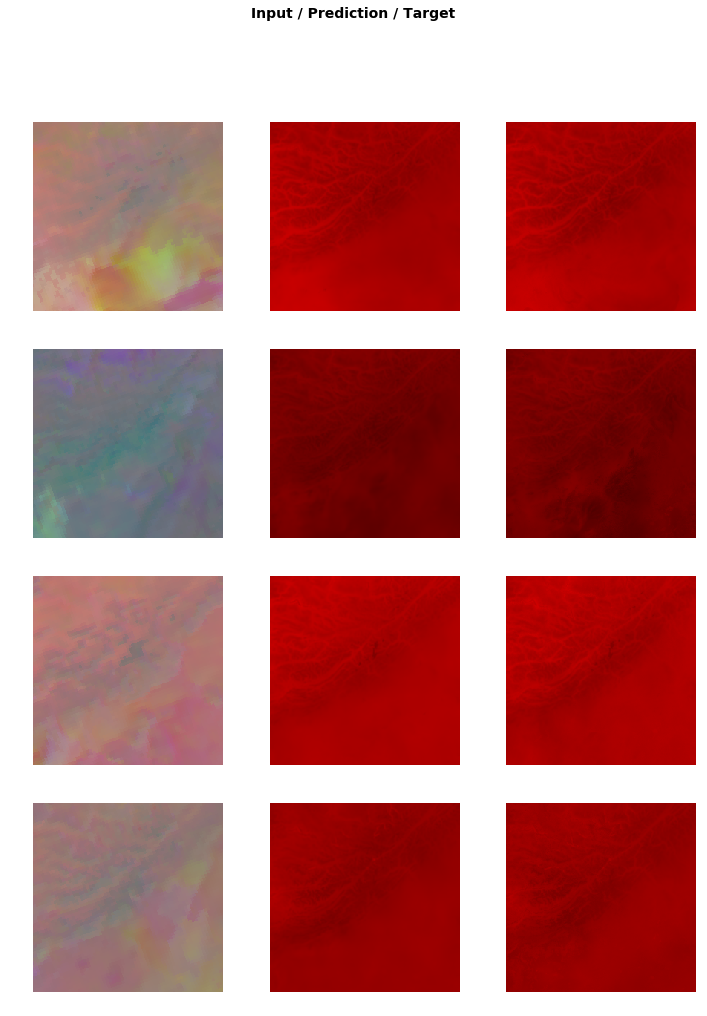

In [13]:
learn_gen.show_results(rows=4)

# Save Generated Images

In [7]:
learn_gen.load('generator-pretrain-2')

Learner(data=ImageDataBunch;

Train: LabelList
y: ImageItemList (5343 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: ../images
x: ImageImageList (5343 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: ../images;

Valid: LabelList
y: ImageItemList (248 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: ../images
x: ImageImageList (248 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: ../images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size

In [8]:
def get_temperature_vector(channel_vector, min_value, max_value):
    """
    Returns a (256,256) float vector ranging from [min_value, max_value].
    
    Arguments:
        channel_vector: a channel with values between [0, 1] 
        min_value: integer, the minimum value of the entire distribution of the vector to return
        max_value: integer, the maximum value of the entire distribution of the vector to return
    """
    return channel_vector * (max_value - min_value) + min_value

In [10]:
def get_temperature_from_pil_image(pil_image):
    """
    Returns a 2d vector (256,256) of temperature value [-50, 50] extracted from the red channel of given image
    
    Arguments:
        pil_image: the PIL Image to extract the red channel from
    """
    img_channels = np.array(pil_image)
    return img_channels[:,:,0] / 256 * 100 - 50

In [39]:
def save_predictions(data_loader, date_indexes, png_output_folder, output_array_filename=None):
    filenames = data_loader.dataset.items
    i=0
    
    # make output folder for all png, if not exist
    path_gen = Path(png_output_folder)
    path_gen.mkdir(exist_ok=True)    

    if output_array_filename is not None:
        temperature_maps = np.zeros(shape=(len(filenames), 1, 256, 256))
    
    for b in data_loader:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        
        for output_image in preds:
            # save png image on disk
            output_image.save(path_gen/filenames[i].name)
            
            if output_array_filename is not None:
                index = np.where(date_indexes == str.encode(Path(filenames[i]).name[:-4]))
                
                # transpose from fastai images shape of (c, h, w) to (h, w, c)
                output_channels = output_image.data.permute(1, 2, 0)                
                # convert the red channel to temperature values and store in the array to be saved
                temperature_maps[index,0,:,:] = get_temperature_vector(output_channels[:,:,0], -50, 50)
            
                #pilimage = PILImage.open(path_gen/filenames[i].name)
                #temperature_maps[index,0,:,:] = get_temperature_from_pil_image(pilimage)

            i += 1
            
    if output_array_filename is not None:
        # save to a .npy file
        np.save(output_array_filename, temperature_maps)
        return temperature_maps
    
    return None

---

In [40]:
date_indexes = np.load('../data/date_test_set.npy')

save_predictions(data_loader.valid_dl, date_indexes, 
                 '../images/image_gen/', output_array_filename='../images/image_gen.npy')

array([[[[ -0.472958,   0.073467,  -0.050568,  -0.409222, ...,  -0.887344,  -0.793678,  -0.938568,  -1.120674],
         [ -0.972027,  -0.667782,  -0.524403,  -0.639145, ...,  -0.543159,  -0.521778,  -0.593418,  -1.32515 ],
         [ -0.494064,  -0.295753,  -0.443123,  -0.398407, ...,  -0.576561,  -0.540943,  -0.612041,  -1.197624],
         [  0.190945,   0.362785,   0.102478,   0.183208, ...,  -1.422638,  -1.38615 ,  -1.292984,  -1.371529],
         ...,
         [-11.711025, -10.663414,  -9.265072,  -8.64584 , ..., -17.630909, -17.738636, -17.488487, -17.749126],
         [-11.678867, -10.435669, -10.602718, -10.200127, ..., -18.018181, -18.183187, -17.646156, -18.051497],
         [-11.811848, -11.513901, -11.954338, -11.039619, ..., -18.27771 , -18.540192, -17.88522 , -17.452824],
         [-12.486309, -12.331001, -12.366932, -11.134426, ..., -18.195646, -18.66799 , -18.451483, -17.554062]]],


       [[[ -0.59314 ,  -0.170692,  -0.215672,  -0.33725 , ...,  -0.966732,  -1.236313,